# Fundamentals of Convolutional Networks - LeNet5

[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/andandand/lenet5-digit-recognition)

#### Author: Antonio Rueda-Toicen

**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

[LeNet-5](https://en.wikipedia.org/wiki/LeNet), developed by Yann LeCun in 1998, was the one of the first architectures that could effectively recognize patterns on images.

LeNet has a simple structure: input layer, two convolutional layers with pooling, followed by fully connected layers. 

LeNet-5 recognizes handwritten digits by using local receptive fields with shared weights and spatial subsampling (pooling) before feeding the resulting downsampled images into fully connected layers. 

This architecture became a blueprint for modern CNNs.

In this notebook, we build it and use it to submit an entry into Kaggle's Digit Recognition Competition.

![](https://raw.githubusercontent.com/andandandand/images-for-colab-notebooks/refs/heads/main/Lenet5.png)

## Set up imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

# Utilities for I/O and file manipulation
import numpy as np
import pandas as pd
import os 
from contextlib import redirect_stdout

## Reproducibility seed and compute device (GPU or CPU)

In [2]:
# Set random seed for reproducibility of all random operations on PyTorch
torch.manual_seed(42)

# Set computing device, "cuda" stands for an Nvidia GPU 
# Data and models will be sent to this device when training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Prepare dataset

In [3]:
# Create an initial transform from PIL to PyTorch tensor to compute mean and standard deviation of the training set
initial_transform = transforms.Compose([transforms.ToImage(),
                                        transforms.ToDtype(torch.float32, scale=True)])

In [4]:
# Define the MNIST Dataset class
class MNISTDataset(Dataset):
    def __init__(self, dataframe, labels=True, transform=None):
        self.data = dataframe
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.labels:
            image = self.data.iloc[idx, 1:].values.astype(np.float32).reshape(28, 28)
            label = self.data.iloc[idx, 0]
        else:
            image = self.data.iloc[idx, :].values.astype(np.float32).reshape(28, 28)
            label = 11  # Placeholder for test data

        if self.transform:
            image = self.transform(image)

         # Ensure tensors are properly detached and typecast
        image_tensor = torch.from_numpy(np.array(image)).clone().detach().float()
        label_tensor = torch.tensor(label).clone().detach().long()

        return image_tensor, label_tensor

# Load the data
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data  = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [5]:
train_data.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_data.head(1)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Create datasets
train_set = MNISTDataset(train_data, labels=True, transform=initial_transform)
test_set = MNISTDataset(test_data, labels=False, transform=initial_transform)

In [8]:
# The images are initially pairs of PIL (Python Image Library) images and their labels
train_set[0]

(tensor([[[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.],
          [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
             0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 188., 255.,
            94.,   0.,   0.,   0.,   0

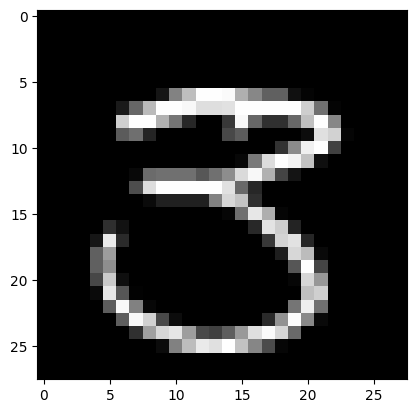

In [9]:
# Each image is 28x28 pixels and represented in grayscale
im = train_set[7][0]
plt.imshow(im.squeeze(), cmap='gray');

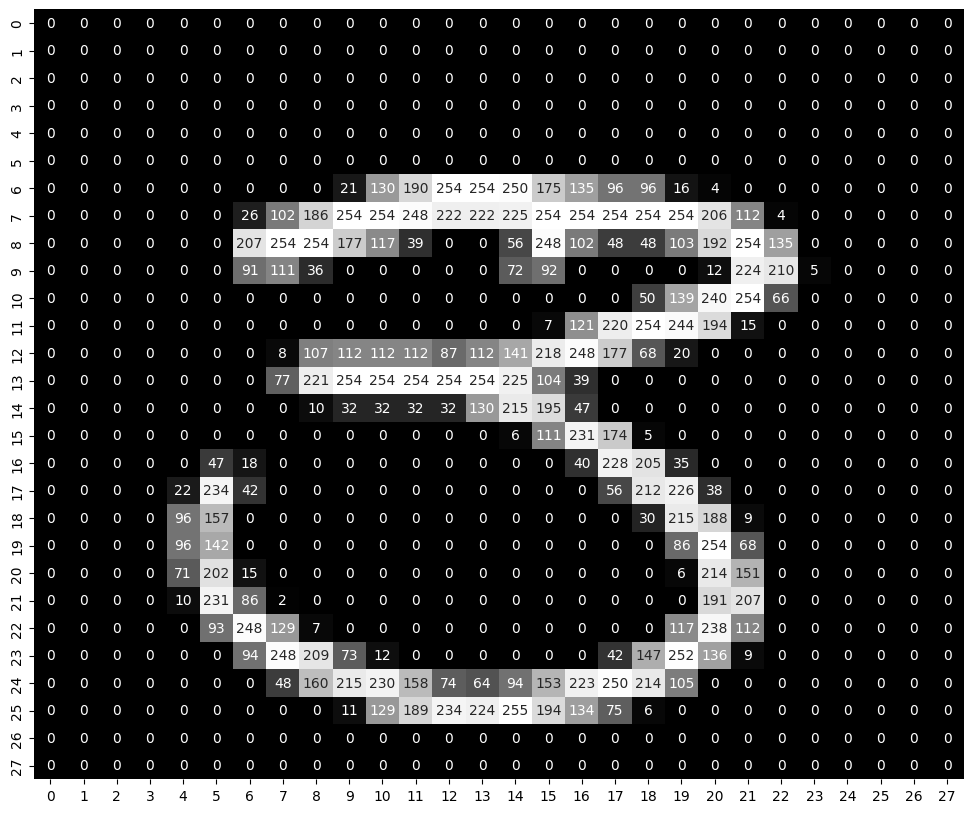

In [10]:
# We use 0 to represent black pixels and 255 to represent white in uint8 (unsigned integers of 8 bits)
df = pd.DataFrame(np.array(im).squeeze())
plt.figure(figsize=(12, 10))
sns.heatmap(df, cmap="Greys_r", annot=True, fmt=".0f", cbar=False)
plt.show()

In [11]:
# We can inspect the values used to represent the image by converting it
# into a Numpy array or PyTorch tensor
arr = np.array(im)

arr.shape

(1, 28, 28)

In [12]:
# The 6:12 asks for the values in the rows from index 6 (included) to 12 (not included) 
# and the same for the columns. NumPy indexes from top to bottom and left to right.
# This section is located in the top-left corner of the image
arr[6:12, 6:12]

array([], shape=(0, 6, 28), dtype=float32)

In [13]:
 
# Here's the same as a PyTorch tensor. 
# We use transforms.ToImage() to convert the PIL image into a PyTorch tensor of unsigned integers
to_imag = transforms.ToImage()
my_tensor = to_imag(im)
# The shape of the tensor includes the number of channels as a first dimension.
# Grayscale images have only 1 channel. This is appended in front of the shape tensor
my_tensor.shape

torch.Size([1, 28, 28])

In [14]:
my_tensor.unsqueeze(0).dim()

4

In [15]:
# We can remove this dimension by using the squeeze() method, afterwards we can index the values just like we did with the numpy array
selection_tensor = my_tensor.squeeze()[6:12, 6:12]
selection_tensor

tensor([[  0.,   0.,   0.,  21., 130., 190.],
        [ 26., 102., 186., 254., 254., 248.],
        [207., 254., 254., 177., 117.,  39.],
        [ 91., 111.,  36.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]])

## Issues with numerical precision

In [16]:
# torch.uint8 can only represent numbers in the range of 0 to 255, this causes issues with common functions
# that we use in neural networks, notice that applying an exponential function to the input will make many values 
# "explode" to infinity, this would destroy information during the training of a neural network 
# In this example selection_tensor is implicitly converted to a torch.float32 when passed to the torch.exp function 
torch.exp(selection_tensor)

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.3188e+09,        inf,        inf],
        [1.9573e+11,        inf,        inf,        inf,        inf,        inf],
        [       inf,        inf,        inf,        inf,        inf, 8.6593e+16],
        [       inf,        inf, 4.3112e+15, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]])

In [17]:
# We can avoid this issue by rescaling the input in the range of 0 to 1 
# Please take note that this division makes an implicit type conversion to torch.float32
# In the following section we will see the more common ways that this scaling is done in PyTorch pipelines
torch.exp(selection_tensor/255)

tensor([[1.0000, 1.0000, 1.0000, 1.0858, 1.6650, 2.1066],
        [1.1073, 1.4918, 2.0739, 2.7076, 2.7076, 2.6447],
        [2.2519, 2.7076, 2.7076, 2.0019, 1.5822, 1.1653],
        [1.4288, 1.5454, 1.1516, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

## Moving and transforming tensors

In [18]:
# We can use PyTorch's 'to' function to move tensors to the GPU (if it is available) and change their data type
float_selection_tensor = selection_tensor.to(device, dtype=torch.float32)
float_selection_tensor

tensor([[  0.,   0.,   0.,  21., 130., 190.],
        [ 26., 102., 186., 254., 254., 248.],
        [207., 254., 254., 177., 117.,  39.],
        [ 91., 111.,  36.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]], device='cuda:0')

In [19]:
# Another way to transform the data type explicitly is to use transforms.ToDtype, notice that here we are using scale=False
# This means that we **don't** re-scale the data to the range 0.0 to 1.0
float32_transform = transforms.ToDtype(torch.float32, scale=False)
float_selection_tensor = float32_transform(selection_tensor)
float_selection_tensor

tensor([[  0.,   0.,   0.,  21., 130., 190.],
        [ 26., 102., 186., 254., 254., 248.],
        [207., 254., 254., 177., 117.,  39.],
        [ 91., 111.,  36.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]])

In [20]:
# Using scale=True will transform the data into the range of 0 to 1 
scaling_transform = transforms.ToDtype(torch.float32, scale=True)
scaling_transform(selection_tensor)

tensor([[  0.,   0.,   0.,  21., 130., 190.],
        [ 26., 102., 186., 254., 254., 248.],
        [207., 254., 254., 177., 117.,  39.],
        [ 91., 111.,  36.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]])

## Input normalization with mean and standard deviation of the training set

The classic paper [Efficient Backprop](https://www.researchgate.net/publication/2811922_Efficient_BackProp) (LeCun et al., 2000) shows empirically that input normalization using the mean and standard deviation of the training set can lead to a 10x improvement in training speed. This practice is widely spread in modern deep learning. Standard scaling transforms the data such that it has a mean of 0 and a standard deviation of 1. This is useful in machine learning algorithms sensitive to the magnitude of features.

We use the standard scaling normalization (also called [z-score normalization](https://en.wikipedia.org/wiki/Standard_score)):

$x^{normalized} = \frac{x - \mu}{\sigma}$

Where:
- $x$ is the input variable
- $\mu$ is the mean of inputs across the training set
- $\sigma$ is the standard deviation across the training set

It represents the distance between the raw input x and the population mean in units of the standard deviation. This distance is negative when the raw score is below the mean and positive when above. 

Implementation in PyTorch or NumPy:
```python
mean = training_data.mean()
std = training_data.std()
normalized_data = (data - mean) / std
```

Input normalization is useful for neural networks for these key reasons:

1. Training Stability: Normalized inputs improve gradient flow through the network. Without normalization, large input values can cascade into exploding gradients (values that go outside of the range that we can represent with the number of bits that we have to represent our activations) and unstable training.

2. Faster Learning: Normalization creates a more spherical loss surface, enabling more direct gradient descent paths and allowing higher learning rates.

3. Better Initialization: Most normalized values fall in ranges where activation functions have stronger gradients, preventing early neuron saturation.

**Important**: Always use training set statistics to normalize both training and test data to maintain consistent transformations.

In [21]:
# Calculate mean and std of training set
train_data = torch.stack([initial_transform(img) for img, _ in train_set])
mean = train_data.mean().item()
std = train_data.std()
print(f"Dataset statistics - Mean: {mean:.4f}, Std: {std:.4f}")

Dataset statistics - Mean: 33.4089, Std: 78.6777


In [22]:
# Now we create a final transformation that will convert the PIL Images to Tensors, scale them, and normalize them
norm_transform = transforms.Compose([transforms.ToImage(),
                                     transforms.ToDtype(torch.float32, scale=True),
                                     transforms.Normalize((mean,), (std,))                       
                                    ])

## Apply transformation to datasets

In [23]:
# This converts every datapoint in the original dataset to scaled and normalized torch tensor
train_set.transform = norm_transform
test_set.transform = norm_transform

In [24]:
# If we inspect an image from the training_set, we see that it has been re-scaled
train_set[0][0].squeeze()[6:12, 6:12]

tensor([[-0.4246, -0.4246, -0.4246, -0.4246, -0.4246, -0.4246],
        [-0.4246, -0.4246, -0.4246, -0.4246, -0.4246, -0.4246],
        [-0.4246, -0.4246, -0.4246, -0.4246, -0.4246, -0.4246],
        [-0.4246, -0.4246, -0.4246, -0.4246, -0.4246, -0.4246],
        [-0.4246, -0.4246, -0.4246, -0.4246, -0.4246, -0.4246],
        [-0.4246, -0.4246, -0.4246, -0.4246, -0.4246, -0.4246]])

In [25]:
train_set[0][0].min(), train_set[0][0].max()

(tensor(-0.4246), tensor(2.8164))

## Create a validation set

In [26]:
# Create validation/test split from the test set
validation_size = int(0.25 * len(train_set))  # Split test set in half
train_size = len(train_set) - validation_size
valid_subset, train_subset = torch.utils.data.random_split(
    train_set, [validation_size, train_size], generator=torch.Generator().manual_seed(42)
)
len(valid_subset), len(train_subset)

(10500, 31500)

## Create dataloaders

In [27]:
# Create data loaders
batch_size = 32
# Notice that we shuffle the training loader, but not the validation or test loaders.
# This practice of shuffling the training set is one of the techniques that have been shown to improve training.
# It is described on LeCun's Efficient Backprop publication, but its origin is likely much earlier.
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_subset, batch_size=batch_size)
test_loader  = DataLoader(test_set, batch_size=batch_size)

In [28]:
# The batch size is the first dimension of the images tensor. Next comes the number of channels and x, y dimensions.
# We have 32 labels, one for each datapoint in the batch. 
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Defining the Model

![](https://raw.githubusercontent.com/andandandand/images-for-colab-notebooks/refs/heads/main/Lenet5.png)

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=1) 
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))          
        x = F.max_pool2d(x, 2)            
        x = F.relu(self.conv2(x))         
        x = F.max_pool2d(x, 2)            
        x = x.view(x.size(0), -1)         
        x = F.relu(self.fc1(x))          
        x = F.relu(self.fc2(x))           
        x = self.fc3(x)                  
        return x


model = LeNet5(num_classes=10)


In [59]:
## Send the model to the GPU's VRAM
model.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [60]:
#Check where the model's weights are 
next(model.parameters()).device

device(type='cuda', index=0)

## Define a loss function and optimizer

In [61]:
loss_function = nn.CrossEntropyLoss()

In [62]:
optimizer = Adam(model.parameters())

## Compute accuracy

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

In [63]:
def get_batch_accuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / output.shape[0]

## Lists to track metrics

In [64]:
# We will use these for plotting 
train_losses = []
train_accuracies = [] 
valid_losses = []
valid_accuracies = []

## Define training

In [65]:
def train():
    total_loss = 0
    total_accuracy = 0
    
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()
        
        total_loss += batch_loss.item()
        total_accuracy += get_batch_accuracy(output, y)
    
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    
    # Store metrics
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    
    print(f'Train - Loss: {avg_loss:.4f} Accuracy: {avg_accuracy:.4f}')
    return avg_loss, avg_accuracy

## Define validation

In [66]:
def validate():
    total_loss = 0
    total_accuracy = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            
            batch_loss = loss_function(output, y)
            total_loss += batch_loss.item()
            total_accuracy += get_batch_accuracy(output, y)
    
    # Calculate average loss and accuracy        
    avg_loss = total_loss / len(valid_loader)
    avg_accuracy = total_accuracy / len(valid_loader)
    
    # Store metrics
    valid_losses.append(avg_loss)
    valid_accuracies.append(avg_accuracy)
    
    print(f'Valid - Loss: {avg_loss:.4f} Accuracy: {avg_accuracy:.4f}')
    return avg_loss, avg_accuracy

## Training config

In [67]:
def get_training_config():
    config = {
        'learning_rate': 0.001,  # Lower learning rate for Adam
        'weight_decay': 1e-4,
        'epochs': 3,
        'min_lr': 1e-6  # Minimum learning rate for scheduler
    }
    return config

config = get_training_config()

In [68]:
optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay']
    )

In [69]:
 # CosineAnnealingLR scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=config['epochs'],
        eta_min=config['min_lr']
    )

## Training loop with model checkpointing

In [70]:
# Training loop with model checkpointing
epochs = config['epochs']
best_valid_accuracy = 0

# CosineAnnealingLR scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=config['epochs'],
        eta_min=config['min_lr']
    )

for epoch in tqdm(range(epochs), desc='Epochs'):
    print(f'\nEpoch: {epoch+1}/{epochs}')
    
    train_loss, train_acc = train()
    valid_loss, valid_acc = validate()

    # Step the scheduler to change the learning rate
    scheduler.step()
    
    # Save model if validation accuracy improves
    if valid_acc > best_valid_accuracy:
        best_valid_accuracy = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model saved! New best validation accuracy: {best_valid_accuracy:.4f}')

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 1/3
Train - Loss: 0.2643 Accuracy: 0.9172


Epochs:  33%|███▎      | 1/3 [00:21<00:42, 21.36s/it]

Valid - Loss: 0.0918 Accuracy: 0.9707
Model saved! New best validation accuracy: 0.9707

Epoch: 2/3
Train - Loss: 0.0772 Accuracy: 0.9759


Epochs:  67%|██████▋   | 2/3 [00:42<00:21, 21.34s/it]

Valid - Loss: 0.0745 Accuracy: 0.9771
Model saved! New best validation accuracy: 0.9771

Epoch: 3/3
Train - Loss: 0.0424 Accuracy: 0.9871


Epochs: 100%|██████████| 3/3 [01:03<00:00, 21.31s/it]

Valid - Loss: 0.0547 Accuracy: 0.9832
Model saved! New best validation accuracy: 0.9832


## Plot training curves

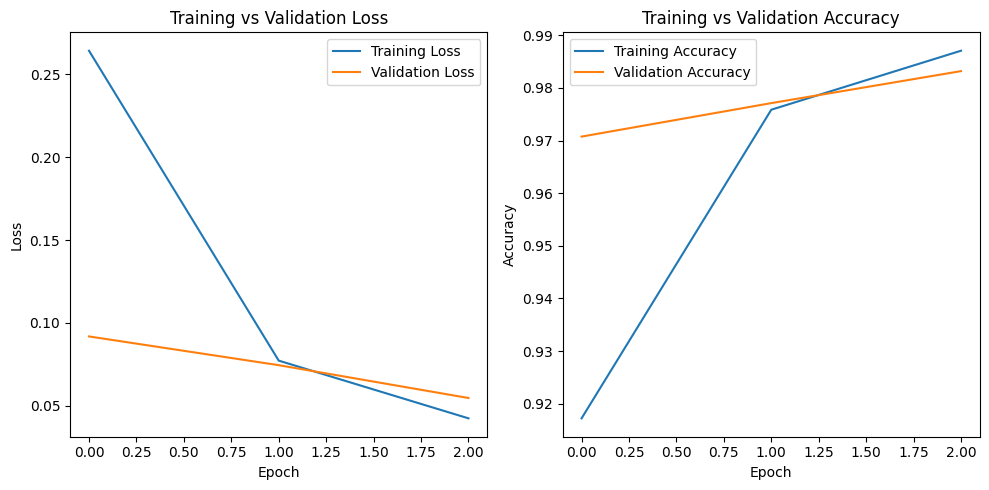

Loaded best model with validation accuracy: 0.9832


In [71]:
# We want to see both validation and training loss going down
plt.figure(figsize=(10, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot accuracies 
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Load best model
model.load_state_dict(torch.load('best_model.pth', weights_only=False))
print(f'Loaded best model with validation accuracy: {best_valid_accuracy:.4f}')

In [72]:
# Evaluate on the test data and prepare a submission
model.eval()
predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Prepare submission
submission = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file created: 'submission.csv'")

Submission file created: 'submission.csv'


## Exercises

* Try logging your experiments with Weights and Biases. For this you will need to create an account on https://wandb.ai/. Refer to [this notebook](https://www.kaggle.com/code/andandand/wandb-resnet-applebananaorange) to give you guidance on how to log experiments on wandb through Kaggle.
* Think about the problem of [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)), that is having testing data in the training set. How could a Kaggler use it to cheat and achieve a "perfect" score of 1.0 accuracy? You can refer to this [Github repo](https://github.com/tesla-is/MNIST-Kaggle-Competition-The-Winning-Solution) and [its discussion on Kaggle](https://www.kaggle.com/c/digit-recognizer/discussion/61480) for ideas.